In [1]:
import os
from os.path import exists
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely import distance
from rich.progress import track

pd.options.mode.chained_assignment = None  # default='warn'

## Parameters and path

In [2]:
um_per_pixel = 0.117
s_per_frame = 0.02
folder_save = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig3_D to organization_exclude hypothesis/boundary_w_tracks_toexcludesurfacebinding"
os.chdir(folder_save)

# load dataset
fname_RNA = "SPT_results_AIO-20221031-FL_noTR_noDex_20ms_0hr_Replicate1_FOV-7-RNAs.csv"
fname_condensate = "condensates_AIO-20221031-FL_noTR_noDex_20ms_0hr_Replicate1_FOV-7-condensates_AveProj_Simple Segmentation.csv"

df_RNA = pd.read_csv(fname_RNA)
df_condensate = pd.read_csv(fname_condensate)

# color
color_condensate_edge = "#00274c"
color_RNA_inside = "#582326"
color_RNA_outside = "#faa613"
scalebar_color = "black"


# scale bar
scalebar_length_um = 5
um_per_pixel = 0.117
scalebar_length_pxl = scalebar_length_um / um_per_pixel

## Functions

In [3]:
def list_like_string_to_xyt(list_like_string):
    # example list_like_string structure of xyt: '[0, 1, 2, 3]'
    list_of_xyt_string = list_like_string[1:-1].split(", ")
    lst_xyt = []
    for xyt_string in list_of_xyt_string:
        lst_xyt.append(float(xyt_string))

    return np.array(lst_xyt, dtype=float)

# Overview Plot

In [4]:
# Add a color column to RNA
new_column = []
for i in track(range(df_RNA.shape[0])):
    row = df_RNA.iloc[i]
    x = list_like_string_to_xyt(row["list_of_x"])
    y = list_like_string_to_xyt(row["list_of_y"])

    # select color based on whether RNA is inside condensate, with non-swapped x and y
    mean_RNA_x = np.mean(x)
    mean_RNA_y = np.mean(y)
    point_RNA = Point(mean_RNA_x, mean_RNA_y)

    # to save computation time, only search for condensates near the RNA
    all_condensateID_nearby = []
    for _, row in df_condensate.iterrows():
        center_x_pxl = row["center_x_pxl"]
        center_y_pxl = row["center_y_pxl"]
        if (center_x_pxl - mean_RNA_x) ** 2 + (
            center_y_pxl - mean_RNA_y
        ) ** 2 > 50**2:
            continue
        else:
            all_condensateID_nearby.append(row["condensateID"])

    dict_condensate_polygons_nearby = dict()
    for condensateID_nearby in all_condensateID_nearby:
        str_condensate_coords = df_condensate[
            df_condensate["condensateID"] == condensateID_nearby
        ]["contour_coord"].squeeze()

        lst_tup_condensate_coords = []
        for str_condensate_xy in str_condensate_coords[2:-2].split("], ["):
            condensate_x, condensate_y = str_condensate_xy.split(", ")
            lst_tup_condensate_coords.append(
                tuple([int(condensate_x), int(condensate_y)])
            )

        dict_condensate_polygons_nearby[condensateID_nearby] = Polygon(
            lst_tup_condensate_coords
        )

    # search for which condensate it's in
    InCondensate = False
    for key, polygon in dict_condensate_polygons_nearby.items():
        # if point_RNA.within(polygon):
        if (
            distance(point_RNA, polygon) < 2
        ):  # redundancy: to include RNAs near boundary
            InCondensate = True
            break
    # save to new column
    new_column.append(InCondensate)

Output()

In [5]:
color_column = np.repeat("spaceholder", df_RNA.shape[0])
color_column[new_column] = color_RNA_inside
color_column[[not x for x in new_column]] = color_RNA_outside


df_RNA_with_color = df_RNA
df_RNA_with_color["color"] = color_column

Output()

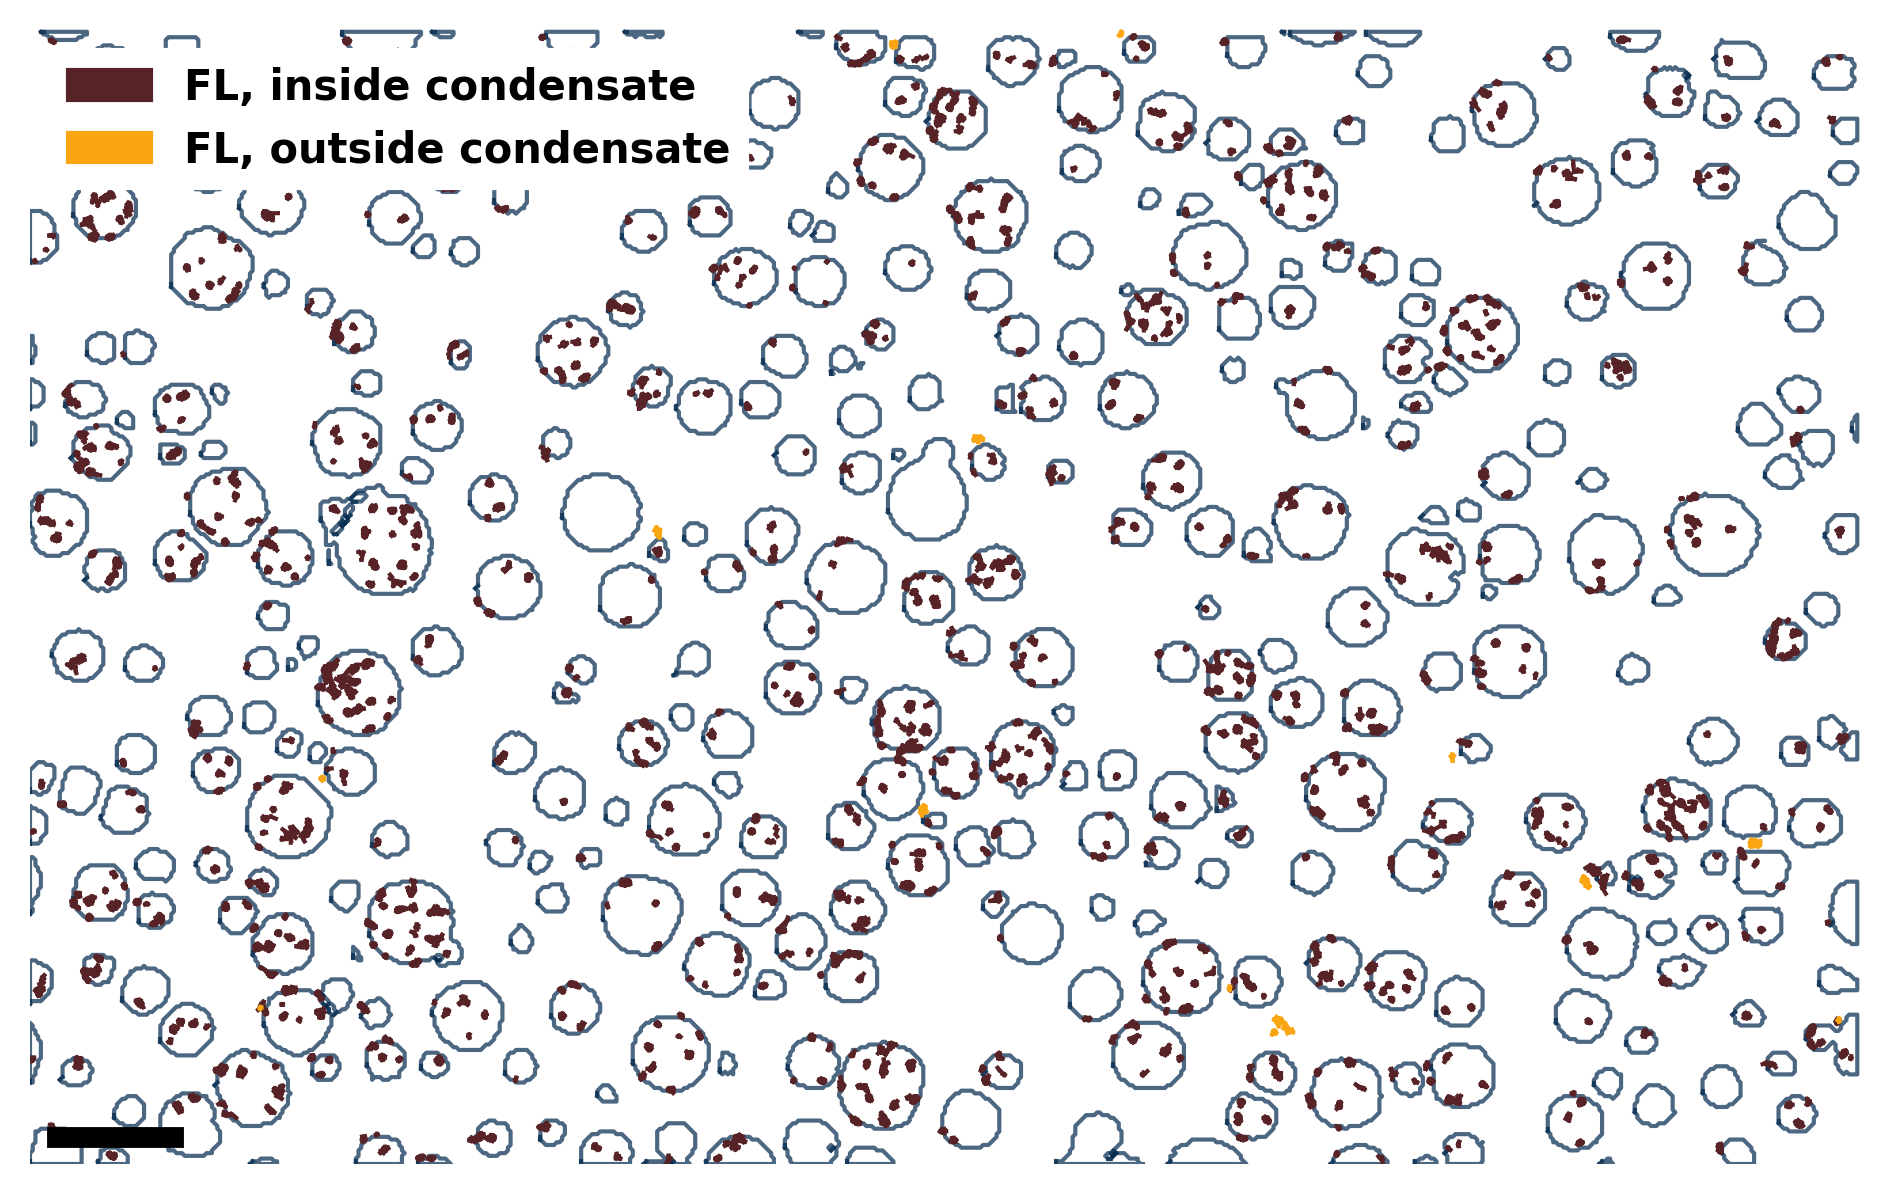

In [14]:
plt.figure(dpi=300)
## plot condensate boundaries, with swapped x and y
for condensateID in df_condensate["condensateID"].unique():
    str_condensate_coords = df_condensate[
        df_condensate["condensateID"] == condensateID
    ]["contour_coord"].squeeze()
    x = []
    y = []
    for str_condensate_xy in str_condensate_coords[2:-2].split("], ["):
        xy = str_condensate_xy.split(", ")
        # swapped x and y
        y.append(int(xy[0]))
        x.append(int(xy[1]))
    plt.plot(x, y, "-", color=color_condensate_edge, linewidth=1, alpha=0.7)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color=color_condensate_edge, linewidth=1, alpha=0.7)

## plot RNA tracks
for idx in track(range(df_RNA_with_color.shape[0])):
    row = df_RNA_with_color.iloc[idx]
    t = list_like_string_to_xyt(row["list_of_t"])
    # swapped x and y
    y = list_like_string_to_xyt(row["list_of_x"])
    x = list_like_string_to_xyt(row["list_of_y"])
    color = row["color"]

    for i in range(len(t) - 1):
        plt.plot(
            x[i : i + 2],
            y[i : i + 2],
            "-",
            color=color,
            linewidth=1,
        )
## Make up legend
legend1 = mpatches.Patch(color=color_RNA_inside, label="FL, inside condensate")
legend2 = mpatches.Patch(color=color_RNA_outside, label="FL, outside condensate")
plt.legend(
    handles=[legend1, legend2],
    loc=2,
    facecolor="white",
    edgecolor="white",
    framealpha=1,
    fontsize=15,
    prop={"weight": "bold"},
)


plt.axis("scaled")
plt.xlim(0, 674)
plt.ylim(0, 418)
plt.axis("off")
plt.tight_layout()
# plot scale bar
plt.plot([10, 10 + scalebar_length_pxl], [10, 10], "-", color=scalebar_color, lw=5)

plt.savefig(
    "Tracks_overlay_condensate.png", bbox_inches="tight", format="png", dpi=1200
)
plt.show()

In [ ]:
# full size: 418x674
zoom_in_x = (13, 45)
zoom_in_y = (297, 330)

saving_switch = True
plot_axis = False
scale_bar_offset = 0

plt.figure(dpi=600, figsize=(5, 4))
## plot condensate boundaries
for condensateID in df_condensate["condensateID"].unique():
    str_condensate_coords = df_condensate[
        df_condensate["condensateID"] == condensateID
    ]["contour_coord"].squeeze()
    x = []
    y = []
    for str_condensate_xy in str_condensate_coords[2:-2].split("], ["):
        xy = str_condensate_xy.split(", ")
        x.append(int(xy[0]))
        y.append(int(xy[1]))
    plt.plot(x, y, "-", color=color_condensate_edge, linewidth=3)
    # still the last closing line will be missing, get it below
    xlast = [x[-1], x[0]]
    ylast = [y[-1], y[0]]
    plt.plot(xlast, ylast, "-", color=color_condensate_edge, linewidth=3)

## plot RNA tracks
t_min = 0
t_max = 0
for _, row in df_RNA.iterrows():
    x = list_like_string_to_xyt(row["list_of_x"])
    y = list_like_string_to_xyt(row["list_of_y"])
    t = list_like_string_to_xyt(row["list_of_t"])
    if (
        (x.mean() > zoom_in_x[0])
        & (x.mean() < zoom_in_x[1])
        & (y.mean() > zoom_in_y[0])
        & (y.mean() < zoom_in_y[1])
    ):
        if t.max() > t_max:
            t_max = t.max()
        for i in range(len(t) - 1):
            plt.plot(
                x[i : i + 2],
                y[i : i + 2],
                "-o",
                color=cmap(np.mean(t[i : i + 2]) / 200),
                linewidth=1,
                markersize=2,
                # alpha=0.5,
            )

plt.tight_layout()
plt.axis("equal")
if not plot_axis:
    plt.axis("off")

# plot color bar for time
cbar = plt.colorbar(
    cm.ScalarMappable(norm=clr.Normalize(0, t_max * s_per_frame), cmap=cmap),
    ax=plt.gca(),
    orientation="vertical",
    pad=0.05,
    drawedges=False,
    ticks=[0, 1, 2, 3],
    extendfrac=0.1,
    extend="max",
)
cbar.set_label(
    label="Time, s",
    weight="bold",
    fontsize=19,
    labelpad=10,
    family="Arial",
)
cbar.ax.tick_params(labelsize=17)

# plot scale bar
plt.xlim(zoom_in_x[0], zoom_in_x[1])
plt.ylim(zoom_in_y[0], zoom_in_y[1])
plt.plot(
    [
        zoom_in_x[0] + scale_bar_offset,
        zoom_in_x[0] + scale_bar_offset + scalebar_length_pxl,
    ],
    [zoom_in_y[0] + scale_bar_offset, zoom_in_y[0] + scale_bar_offset],
    "-",
    color=scalebar_color,
    lw=15,
)

if saving_switch:
    i = 0
    fname_save = (
        "Fig1_c_boundary_w_RNAtracks_zoomin-"
        + "x_"
        + str(zoom_in_x[0])
        + "_"
        + str(zoom_in_x[1])
        + "_y_"
        + str(zoom_in_y[0])
        + "_"
        + str(zoom_in_y[1])
        + ".png"
    )
    while exists(fname_save[:-4] + "-" + str(i) + ".png"):
        i += 1
    fname_save = fname_save[:-4] + "-" + str(i) + ".png"

    plt.savefig(fname_save, format="png", bbox_inches="tight")

plt.show()